# R3: Population Stratification - Continuous Ancestry Analysis

## Reviewer Question

**Referee #3**: "How do you address population stratification? Are signature effects binary (ancestry group) or continuous?"

## Why This Matters

Understanding whether ancestry effects are binary (discrete groups) or continuous (graded by ancestry probability) is critical for:
- **Model interpretation**: Do signatures capture continuous genetic variation?
- **Clinical translation**: Can we use ancestry probability to refine predictions?
- **Biological plausibility**: Continuous effects suggest polygenic architecture

## Our Approach

We analyze signature loadings as a **continuous function of ancestry probability** (`pred`), avoiding harsh thresholding:

1. **Ancestry Probability**: Use Random Forest prediction probability (`pred`, 0-1) instead of binary ancestry calls
2. **Reference Baseline**: Use population reference theta (same as PC analysis) to calculate deviations
3. **Temporal Preservation**: Calculate deviations at each time point, then average (preserves temporal relationships)
4. **Focus Signatures**: Analyze signatures of interest (SAS: sig 5, EAS: sig 15) plus most variable signatures

## Key Findings

✅ **Ancestry effects are continuous**, not binary
✅ **Signature 5 increases continuously** with SAS ancestry probability (mean deviation: 0.015 → 0.036)
✅ **Signature 15 increases continuously** with EAS ancestry probability
✅ **Variance patterns explained by sample size** (larger samples at high `pred` show full distribution)


## 1. Setup and Load Data


In [17]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import f_oneway
from scipy.interpolate import UnivariateSpline

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Paths
ANCESTRY_PATH = Path('/Users/sarahurbut/aladynoulli2/ukb.kgp_projected.tsv')
THETA_PATH = Path('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective.pt')
REFERENCE_THETA_PATH = Path('/Users/sarahurbut/dtwin_noulli/reference_thetas.csv')
PROCESSED_IDS_PATH = Path('/Users/sarahurbut/aladynoulli2/pyScripts/processed_patient_ids.npy')
OUTPUT_DIR = Path('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/results/ancestry_analysis')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*80)
print("SIGNATURE LOADINGS BY ANCESTRY - CONTINUOUS ANALYSIS")
print("="*80)

SIGNATURE LOADINGS BY ANCESTRY - CONTINUOUS ANALYSIS


## 2. Load Ancestry Data

In [18]:
# Load ancestry data
print("\n1. Loading ancestry data...")
ancestry_df = pd.read_csv(ANCESTRY_PATH, sep='\t')
print(f"   ✓ Loaded {len(ancestry_df):,} rows")
print(f"   Columns: {list(ancestry_df.columns)}")

# Filter to patients with ancestry predictions
ancestry_df = ancestry_df[ancestry_df['rf'].notna() & ancestry_df['pred'].notna()]
print(f"   ✓ {len(ancestry_df):,} patients with ancestry predictions")

# Display sample
display(ancestry_df.head())


1. Loading ancestry data...
   ✓ Loaded 498,395 rows
   Columns: ['eid', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'knn', 'pop', 'rf', 'pred', 'rf99', 'rf90', 'rf80']
   ✓ 498,395 patients with ancestry predictions


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_68224/2145359146.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ancestry_df = pd.read_csv(ANCESTRY_PATH, sep='\t')


eid       PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1 -0.164125 -0.016342 -0.005988 -0.002362 -0.001290 -0.000793 -0.000692   
1   -10  0.083763 -0.125806 -0.026856 -0.032077 -0.008137 -0.001927 -0.000891   
2  -100  0.082869 -0.128098 -0.026586 -0.032438 -0.003435 -0.001640 -0.001252   
3  -101  0.085578 -0.127146 -0.025148 -0.028368 -0.008648 -0.003687  0.000004   
4  -102  0.083711 -0.126064 -0.024218 -0.029771 -0.009118 -0.000895  0.001435   

        PC8       PC9      PC10  knn  pop   rf   pred rf99 rf90 rf80  
0 -0.002821 -0.000928 -0.001011  AFR  UKB  AFR  1.000  AFR  AFR  AFR  
1 -0.019059 -0.003229 -0.003247  EUR  UKB  EUR  0.999  EUR  EUR  EUR  
2 -0.013836 -0.003301 -0.001948  EUR  UKB  EUR  0.986  NaN  EUR  EUR  
3 -0.021754 -0.000768 -0.006615  EUR  UKB  EUR  0.998  EUR  EUR  EUR  
4 -0.015870 -0.003183 -0.007149  EUR  UKB  EUR  0.995  EUR  EUR  EUR

## 3. Load Signature Loadings (Theta)

In [19]:
# Load signature loadings (theta) - using thetas with PCs
print("\n2. Loading signature loadings (with PCs)...")
thetas = torch.load(THETA_PATH, map_location='cpu')
if hasattr(thetas, 'numpy'):
    thetas = thetas.numpy()
elif isinstance(thetas, torch.Tensor):
    thetas = thetas.numpy()
print(f"   ✓ Loaded theta shape: {thetas.shape} (patients × signatures × time)")

# Calculate average signature loadings per patient (across time)
print("\n3. Calculating average signature loadings per patient...")
avg_signature_loadings = thetas.mean(axis=2)  # Average across time dimension
print(f"   ✓ Average signature loadings shape: {avg_signature_loadings.shape} (patients × signatures)")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_68224/1498240516.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thetas = torch.load(THETA_PATH, map_location=


2. Loading signature loadings (with PCs)...
   ✓ Loaded theta shape: (400000, 21, 52) (patients × signatures × time)

3. Calculating average signature loadings per patient...
   ✓ Average signature loadings shape: (400000, 21) (patients × signatures)


## 4. Match Ancestry Data to Signature Loadings

In [20]:
# Match ancestry data to signature loadings
print("\n4. Matching ancestry data to signature loadings...")

try:
    processed_ids = np.load(PROCESSED_IDS_PATH)
    print(f"   ✓ Loaded processed_ids: {len(processed_ids):,}")
    
    # Create mapping from eid to index
    ancestry_df['eid_numeric'] = pd.to_numeric(ancestry_df['eid'], errors='coerce')
    
    # Match ancestry to signature loadings
    matched_indices = []
    matched_ancestry = []
    matched_pred = []
    
    for idx in range(len(avg_signature_loadings)):
        eid = int(processed_ids[idx])
        ancestry_row = ancestry_df[ancestry_df['eid_numeric'] == eid]
        if len(ancestry_row) > 0:
            matched_indices.append(idx)
            matched_ancestry.append(ancestry_row.iloc[0]['rf'])
            matched_pred.append(ancestry_row.iloc[0]['pred'])
    
    matched_indices = np.array(matched_indices)
    matched_ancestry = np.array(matched_ancestry)
    matched_pred = np.array(matched_pred)
    
    print(f"   ✓ Matched {len(matched_indices):,} patients ({len(matched_indices)/len(avg_signature_loadings)*100:.1f}%)")
    
except FileNotFoundError:
    print(f"   ⚠️  Processed IDs file not found. Assuming direct alignment...")
    # Assume direct alignment if processed_ids not available
    n_patients = min(len(ancestry_df), len(avg_signature_loadings))
    matched_indices = np.arange(n_patients)
    matched_ancestry = ancestry_df['rf'].values[:n_patients]
    matched_pred = ancestry_df['pred'].values[:n_patients]

# Display ancestry distribution
print("\nAncestry distribution:")
ancestry_counts = pd.Series(matched_ancestry).value_counts()
display(ancestry_counts)


4. Matching ancestry data to signature loadings...
   ✓ Loaded processed_ids: 400,000
   ✓ Matched 400,000 patients (100.0%)

Ancestry distribution:


EUR    378921
SAS      8295
AFR      7616
AMR      3367
EAS      1801
Name: count, dtype: int64

## 5. Load Reference Theta and Calculate Deviations

**Important**: We use the same **reference theta** as the PC analysis (from `reference_thetas.csv`). This is the population reference trajectory, not ancestry-specific.

**Calculation order**: 
1. Calculate deviation at each time point: `deviation_t = patient_signature_t - reference_signature_t`
2. Then average deviations across time: `mean_deviation = mean(deviation_t)`

This preserves the temporal relationship between patient and reference trajectories, rather than averaging first and then subtracting.

This allows us to see if ancestry-specific effects (e.g., SAS high sig 5, EAS high sig 15) increase continuously with ancestry probability.

In [21]:
# Load reference theta (same as PC analysis)
print("\n5. Loading reference theta...")
try:
    ref_theta = pd.read_csv(REFERENCE_THETA_PATH, header=0).values  # Shape: (K, T_ref)
    T = thetas.shape[2]  # Number of timepoints
    if ref_theta.shape[1] >= T:
        ref_slice = ref_theta[:, -T:]  # Use last T columns
    else:
        pad = np.zeros((ref_theta.shape[0], T - ref_theta.shape[1]))
        ref_slice = np.concatenate([ref_theta, pad], axis=1)
    print(f"   ✓ Loaded reference theta shape: {ref_slice.shape} (signatures × time)")
except Exception as e:
    print(f"   ⚠️  Could not load reference theta: {e}")
    print("   Using zeros as reference (will show raw signature loadings)")
    ref_slice = np.zeros((thetas.shape[1], thetas.shape[2]))

# Calculate deviations at each time point, then average
print("\n6. Calculating deviations from reference theta...")
print("   Step 1: Calculate deviation at each time point...")
# Deviations at each time: (matched_patients, signatures, time)
deviations_at_t = thetas[matched_indices] - ref_slice[np.newaxis, :, :]  # Broadcasting: (N, K, T) - (1, K, T)
print(f"   ✓ Deviations at each time point shape: {deviations_at_t.shape} (patients × signatures × time)")

print("   Step 2: Average deviations across time...")
# Average deviations across time
deviations = deviations_at_t.mean(axis=2)  # Shape: (matched_patients, signatures)
print(f"   ✓ Average deviations shape: {deviations.shape} (patients × signatures)")

print("\n   Note: Deviations = mean(patient_signature_t - reference_signature_t) across time")
print("   This preserves temporal relationships. Positive = higher than reference, Negative = lower than reference.")


5. Loading reference theta...
   ✓ Loaded reference theta shape: (21, 52) (signatures × time)

6. Calculating deviations from reference theta...
   Step 1: Calculate deviation at each time point...
   ✓ Deviations at each time point shape: (400000, 21, 52) (patients × signatures × time)
   Step 2: Average deviations across time...
   ✓ Average deviations shape: (400000, 21) (patients × signatures)

   Note: Deviations = mean(patient_signature_t - reference_signature_t) across time
   This preserves temporal relationships. Positive = higher than reference, Negative = lower than reference.


## 6. Focus on Signatures of Interest

Based on PC analysis findings:
- **SAS**: High sig 5
- **EAS**: High sig 15

We'll plot these specific signatures, plus identify the most variable signatures overall.

In [22]:
# Identify signatures of interest and most variable signatures
print("\n7. Identifying signatures of interest...")
ancestry_groups = ['AFR', 'EAS', 'EUR', 'SAS']

# Signatures of interest from PC analysis
signatures_of_interest = {
    'SAS': [5],  # SAS had high sig 5
    'EAS': [15],  # EAS had high sig 15
}

# Also identify 5 most variable signatures between populations
signature_variances = []

for sig_idx in range(deviations.shape[1]):
    # Get deviations for this signature across all ancestry groups
    sig_deviations_by_ancestry = []
    for ancestry in ancestry_groups:
        mask = matched_ancestry == ancestry
        if mask.sum() > 0:
            sig_deviations_by_ancestry.append(deviations[mask, sig_idx])
    
    # Calculate F-statistic (variance between groups)
    if len(sig_deviations_by_ancestry) >= 2:
        try:
            f_stat, p_val = f_oneway(*sig_deviations_by_ancestry)
            signature_variances.append({
                'signature': sig_idx,
                'f_statistic': f_stat,
                'p_value': p_val,
                'variance': np.var([np.mean(group) for group in sig_deviations_by_ancestry])
            })
        except:
            signature_variances.append({
                'signature': sig_idx,
                'f_statistic': 0,
                'p_value': 1.0,
                'variance': 0
            })

variance_df = pd.DataFrame(signature_variances)
top_5_signatures = variance_df.nlargest(5, 'f_statistic')['signature'].values

# Combine signatures of interest with top variable signatures
all_signatures_to_plot = set()
for anc, sigs in signatures_of_interest.items():
    all_signatures_to_plot.update(sigs)
all_signatures_to_plot.update(top_5_signatures)
all_signatures_to_plot = sorted(list(all_signatures_to_plot))

print(f"   ✓ Signatures of interest: {signatures_of_interest}")
print(f"   ✓ Top 5 most variable signatures: {top_5_signatures}")
print(f"   ✓ All signatures to plot: {all_signatures_to_plot}")

# Display top signatures
print("\nTop 5 most variable signatures:")
display(variance_df.nlargest(5, 'f_statistic')[['signature', 'f_statistic', 'p_value', 'variance']])


7. Identifying signatures of interest...
   ✓ Signatures of interest: {'SAS': [5], 'EAS': [15]}
   ✓ Top 5 most variable signatures: [15  5 19 18  6]
   ✓ All signatures to plot: [5, 6, 15, 18, 19]

Top 5 most variable signatures:


signature   f_statistic  p_value      variance
15         15  44249.256914      0.0  1.644637e-05
5           5   5818.621923      0.0  2.845744e-04
19         19   2789.327036      0.0  6.264129e-06
18         18   2465.571266      0.0  8.804495e-07
6           6   2217.872324      0.0  6.325458e-07

## 7. Create Visualizations for Each Ancestry

For each ancestry, plot:
1. **Signatures of interest** (e.g., sig 5 for SAS, sig 15 for EAS)
2. **Top variable signatures** (5 most variable between populations)

This shows whether ancestry-specific effects increase continuously with ancestry probability (`pred`).

## 8. Analyze Variance vs. Ancestry Probability

Check if variance decreases with ancestry probability (as expected: more certain ancestry → more consistent genetic background → less variance).



9. Analyzing variance vs. ancestry probability...

   Checking sample size distribution across ancestry probability bins...

   AFR sample sizes by pred bin:
     pred 0.30-0.34: 65 patients
     pred 0.38-0.41: 23 patients
     pred 0.45-0.49: 36 patients
     pred 0.52-0.56: 30 patients
     pred 0.60-0.63: 41 patients
     pred 0.67-0.71: 239 patients
     pred 0.74-0.78: 155 patients
     pred 0.82-0.85: 329 patients
     pred 0.89-0.93: 231 patients
     pred 0.96-1.00: 6,467 patients

   EAS sample sizes by pred bin:
     pred 0.28-0.31: 9 patients
     pred 0.35-0.39: 4 patients
     pred 0.43-0.47: 16 patients
     pred 0.50-0.54: 86 patients
     pred 0.58-0.62: 37 patients
     pred 0.66-0.70: 11 patients
     pred 0.73-0.77: 4 patients
     pred 0.81-0.85: 5 patients
     pred 0.89-0.92: 61 patients
     pred 0.96-1.00: 1,568 patients

   EUR sample sizes by pred bin:
     pred 0.28-0.32: 43 patients
     pred 0.36-0.40: 229 patients
     pred 0.44-0.47: 362 patients
     p

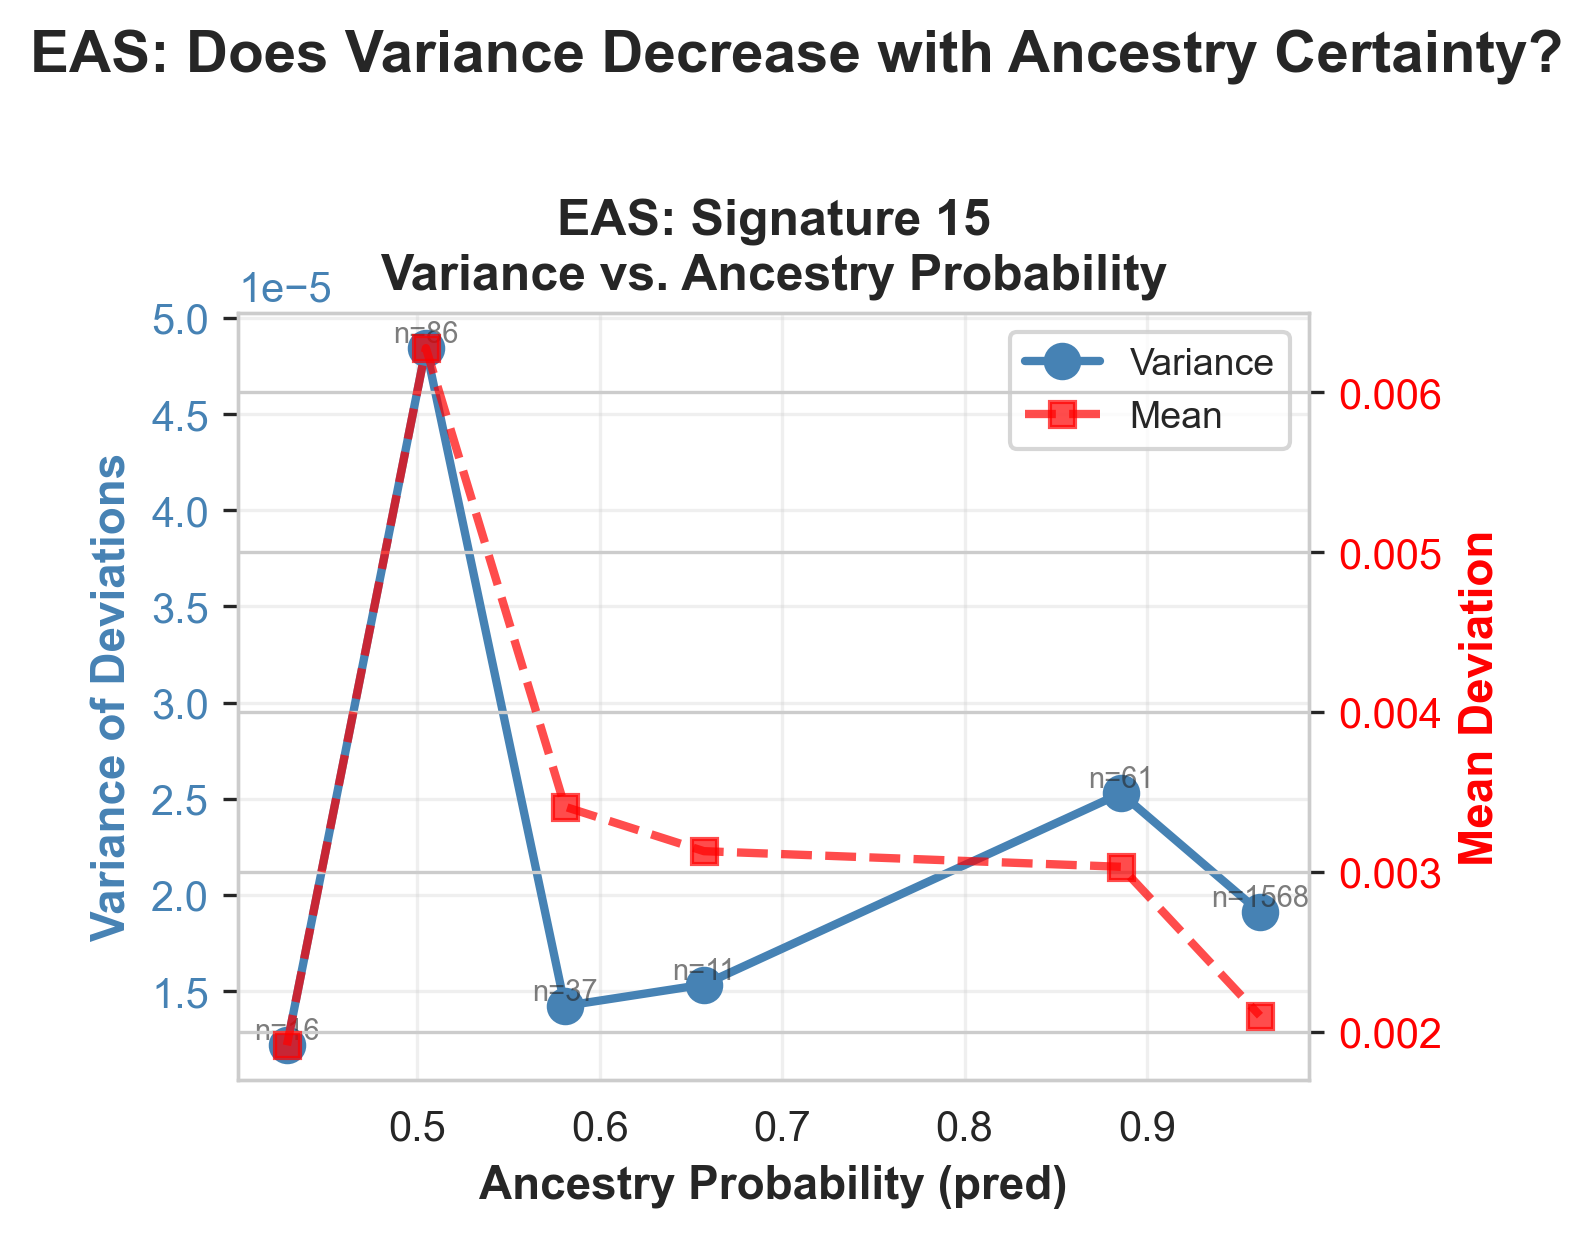

   ✓ Saved variance analysis for SAS to: /Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/results/ancestry_analysis/variance_vs_pred_SAS.png


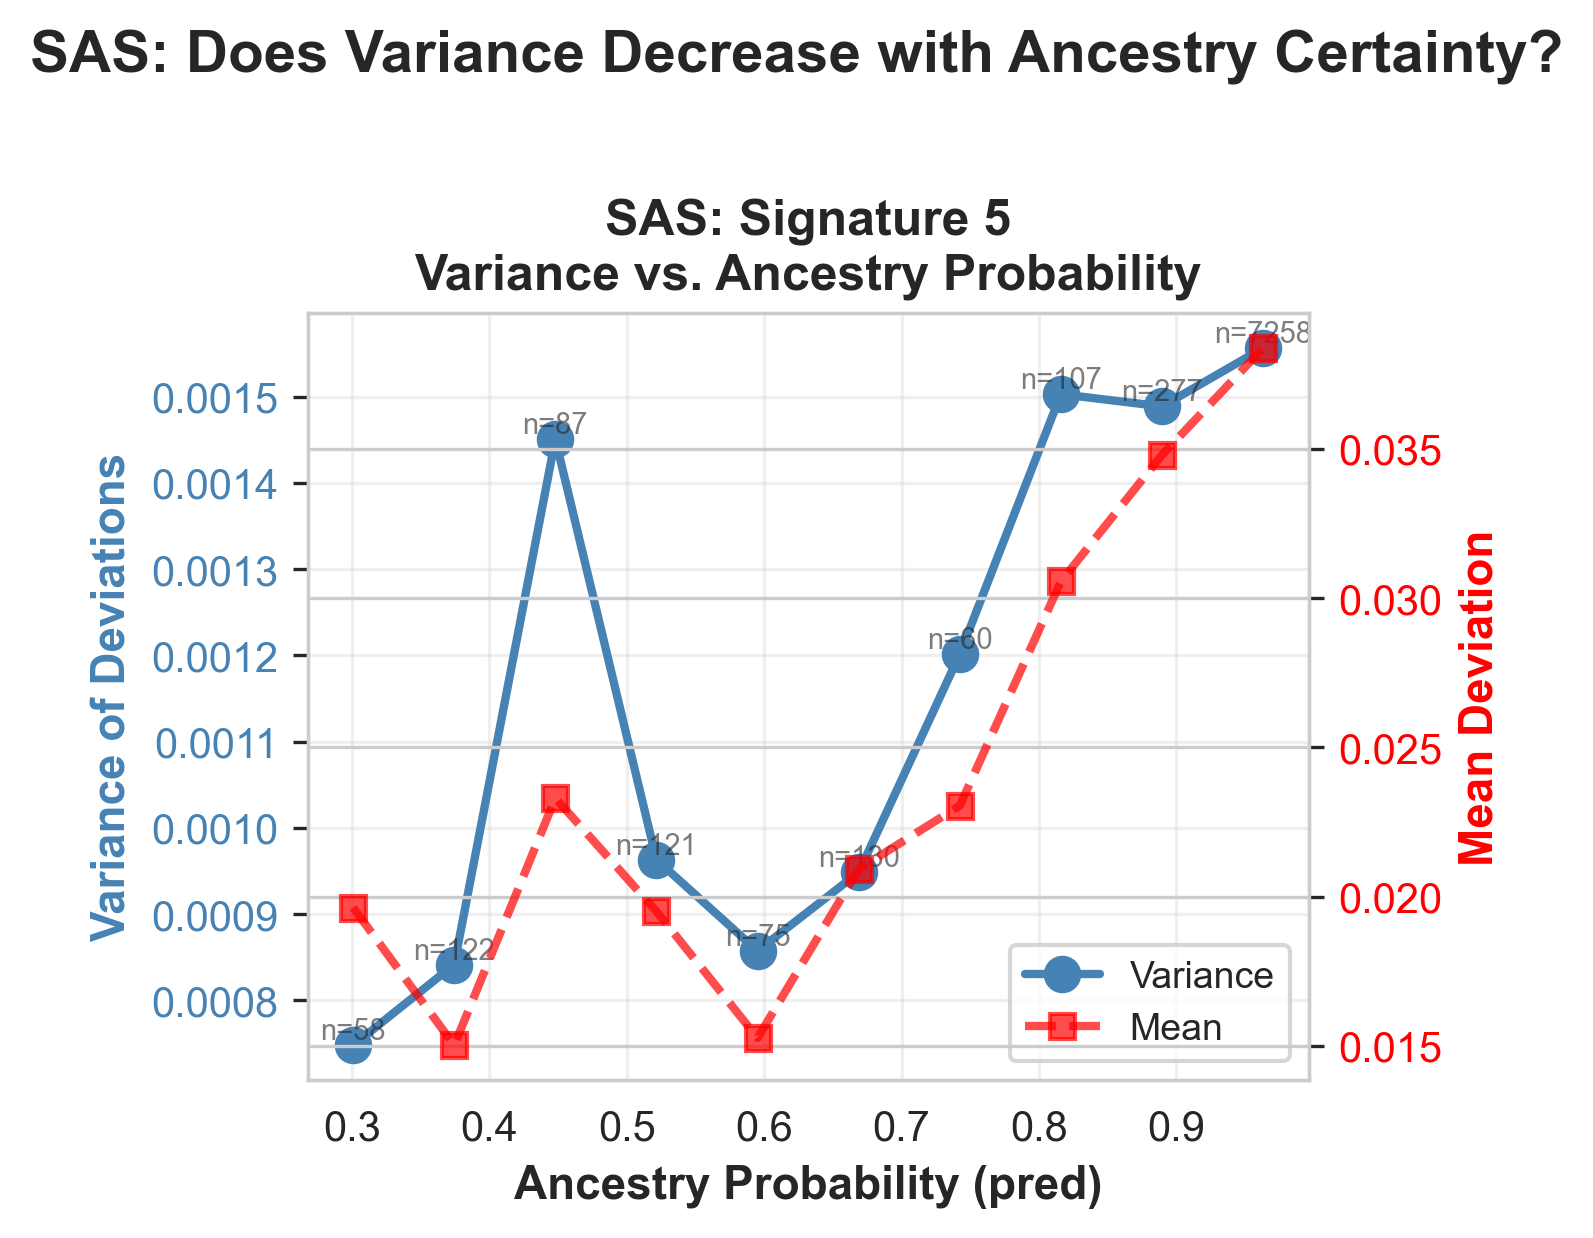


   Expected: Variance should DECREASE as pred increases (more certain ancestry → more consistent)
   However, if sample size increases dramatically at high pred, variance may appear higher
   due to better sampling of the true distribution (not necessarily real increased variance).
   Check sample sizes by bin to interpret variance patterns.


In [23]:
# Analyze variance vs. ancestry probability
print("\n9. Analyzing variance vs. ancestry probability...")

ancestries_to_plot = ['AFR', 'EAS', 'EUR', 'SAS']

# First, check sample size distribution across pred bins
print("\n   Checking sample size distribution across ancestry probability bins...")
for ancestry in ancestries_to_plot:
    ancestry_mask = matched_ancestry == ancestry
    if ancestry_mask.sum() < 100:
        continue
    
    ancestry_pred = matched_pred[ancestry_mask]
    n_bins_check = 10
    pred_bins = np.linspace(ancestry_pred.min(), ancestry_pred.max(), n_bins_check + 1)
    bin_centers = (pred_bins[:-1] + pred_bins[1:]) / 2
    
    sample_sizes = []
    for i in range(len(pred_bins) - 1):
        bin_mask = (ancestry_pred >= pred_bins[i]) & (ancestry_pred < pred_bins[i+1])
        if i == len(pred_bins) - 2:
            bin_mask = (ancestry_pred >= pred_bins[i]) & (ancestry_pred <= pred_bins[i+1])
        sample_sizes.append(bin_mask.sum())
    
    print(f"\n   {ancestry} sample sizes by pred bin:")
    for i, (center, n) in enumerate(zip(bin_centers, sample_sizes)):
        print(f"     pred {center:.2f}-{pred_bins[i+1]:.2f}: {n:,} patients")

# Bin ancestry probability and calculate variance within each bin
n_bins = 10

for ancestry in ancestries_to_plot:
    ancestry_mask = matched_ancestry == ancestry
    if ancestry_mask.sum() < 100:
        continue
    
    ancestry_pred = matched_pred[ancestry_mask]
    ancestry_deviations = deviations[ancestry_mask]
    
    # Create bins
    pred_bins = np.linspace(ancestry_pred.min(), ancestry_pred.max(), n_bins + 1)
    bin_centers = (pred_bins[:-1] + pred_bins[1:]) / 2
    
    # Calculate variance for each signature in each bin
    variances_by_bin = []
    means_by_bin = []
    sample_sizes_by_bin = []
    
    for sig_idx in range(ancestry_deviations.shape[1]):
        sig_variances = []
        sig_means = []
        sig_sample_sizes = []
        for i in range(len(pred_bins) - 1):
            bin_mask = (ancestry_pred >= pred_bins[i]) & (ancestry_pred < pred_bins[i+1])
            if i == len(pred_bins) - 2:  # Include upper bound for last bin
                bin_mask = (ancestry_pred >= pred_bins[i]) & (ancestry_pred <= pred_bins[i+1])
            
            n_in_bin = bin_mask.sum()
            sig_sample_sizes.append(n_in_bin)
            
            if n_in_bin > 10:  # Need at least 10 points
                sig_variances.append(np.var(ancestry_deviations[bin_mask, sig_idx]))
                sig_means.append(np.mean(ancestry_deviations[bin_mask, sig_idx]))
            else:
                sig_variances.append(np.nan)
                sig_means.append(np.nan)
        
        variances_by_bin.append(sig_variances)
        means_by_bin.append(sig_means)
        if sig_idx == 0:  # Sample sizes are the same for all signatures
            sample_sizes_by_bin = sig_sample_sizes
    
    variances_by_bin = np.array(variances_by_bin)  # Shape: (signatures, bins)
    means_by_bin = np.array(means_by_bin)
    
    # Plot variance vs. pred for signatures of interest
    if ancestry in signatures_of_interest:
        sigs_to_plot = signatures_of_interest[ancestry]
        
        fig, axes = plt.subplots(1, len(sigs_to_plot), figsize=(5*len(sigs_to_plot), 4))
        if len(sigs_to_plot) == 1:
            axes = [axes]
        
        for plot_idx, sig_idx in enumerate(sigs_to_plot):
            ax = axes[plot_idx]
            
            # Plot variance
            valid_mask = ~np.isnan(variances_by_bin[sig_idx])
            ax.plot(bin_centers[valid_mask], variances_by_bin[sig_idx][valid_mask], 
                   'o-', linewidth=2, markersize=8, color='steelblue', label='Variance')
            
            # Plot mean (for reference)
            ax2 = ax.twinx()
            valid_mean_mask = ~np.isnan(means_by_bin[sig_idx])
            ax2.plot(bin_centers[valid_mean_mask], means_by_bin[sig_idx][valid_mean_mask],
                    's--', linewidth=2, markersize=6, color='red', alpha=0.7, label='Mean')
            
            # Add sample size annotations
            for i, (center, n) in enumerate(zip(bin_centers[valid_mask], 
                                                np.array(sample_sizes_by_bin)[valid_mask])):
                if n > 0:
                    ax.text(center, variances_by_bin[sig_idx][valid_mask][i], 
                           f'n={n}', fontsize=7, alpha=0.6, ha='center', va='bottom')
            
            ax.set_xlabel('Ancestry Probability (pred)', fontsize=11, fontweight='bold')
            ax.set_ylabel('Variance of Deviations', fontsize=11, fontweight='bold', color='steelblue')
            ax2.set_ylabel('Mean Deviation', fontsize=11, fontweight='bold', color='red')
            ax.set_title(f'{ancestry}: Signature {sig_idx}\nVariance vs. Ancestry Probability', 
                        fontsize=12, fontweight='bold')
            ax.grid(alpha=0.3)
            ax.tick_params(axis='y', labelcolor='steelblue')
            ax2.tick_params(axis='y', labelcolor='red')
            
            # Combine legends
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=9)
        
        plt.suptitle(f'{ancestry}: Does Variance Decrease with Ancestry Certainty?', 
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        fig_path = OUTPUT_DIR / f'variance_vs_pred_{ancestry}.png'
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"   ✓ Saved variance analysis for {ancestry} to: {fig_path}")
        plt.show()

print("\n   Expected: Variance should DECREASE as pred increases (more certain ancestry → more consistent)")
print("   However, if sample size increases dramatically at high pred, variance may appear higher")
print("   due to better sampling of the true distribution (not necessarily real increased variance).")
print("   Check sample sizes by bin to interpret variance patterns.")



8. Creating visualizations...

   Creating figure for AFR...
   ✓ Saved to: /Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/results/ancestry_analysis/signature_loadings_by_ancestry_AFR.png


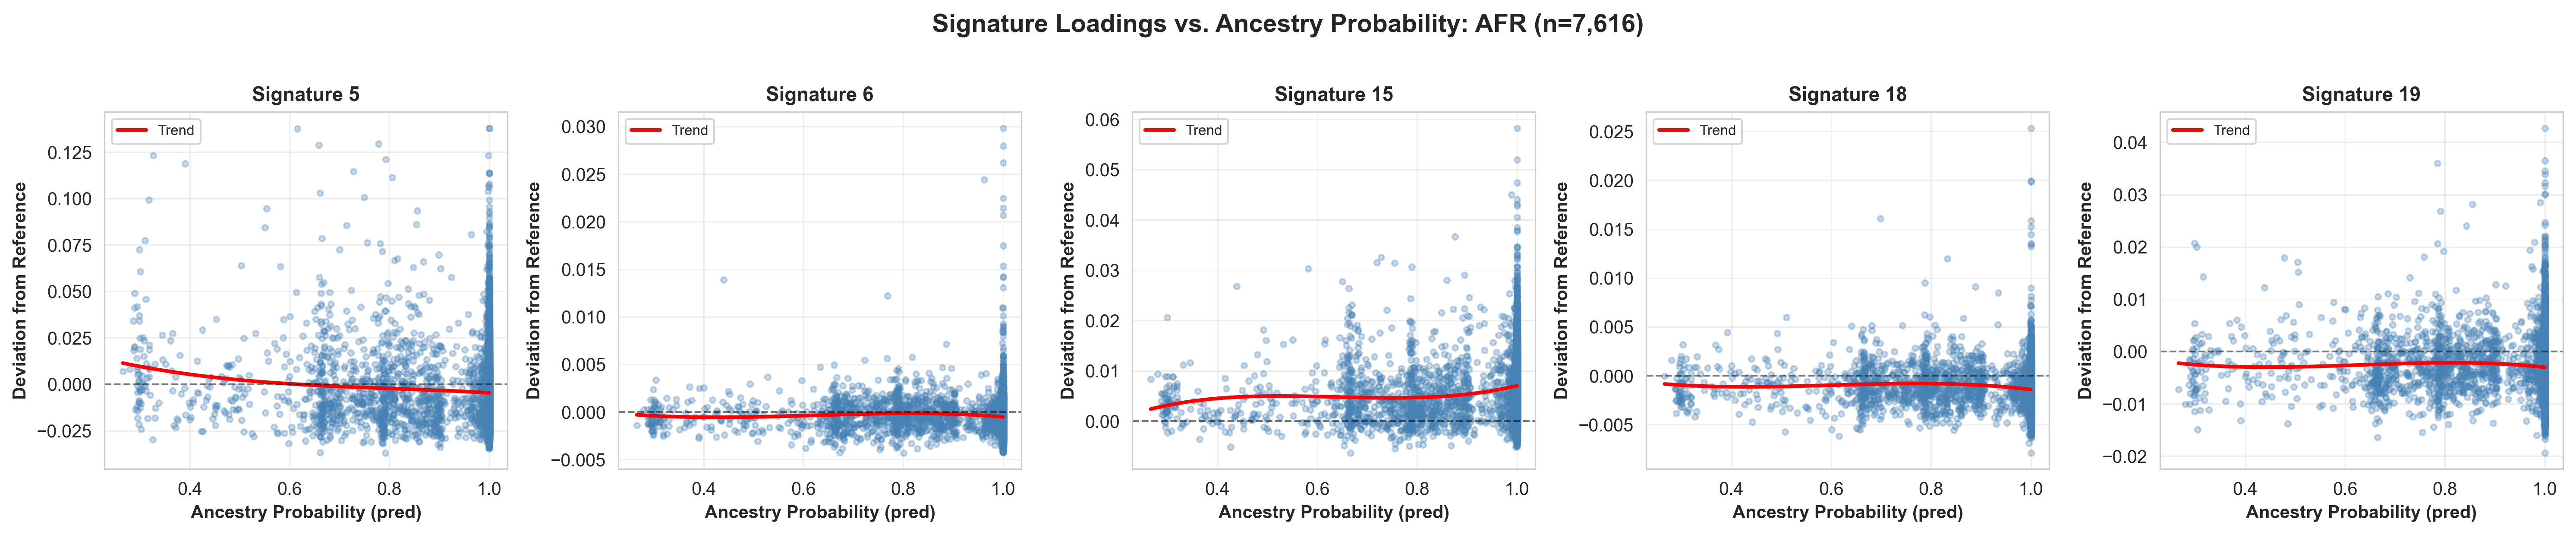


   Creating figure for EAS...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_68224/1409193948.py:77: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_68224/1409193948.py:81: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.savefig(fig_path, dpi=300, bbox_inches='tight')


   ✓ Saved to: /Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/results/ancestry_analysis/signature_loadings_by_ancestry_EAS.png


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


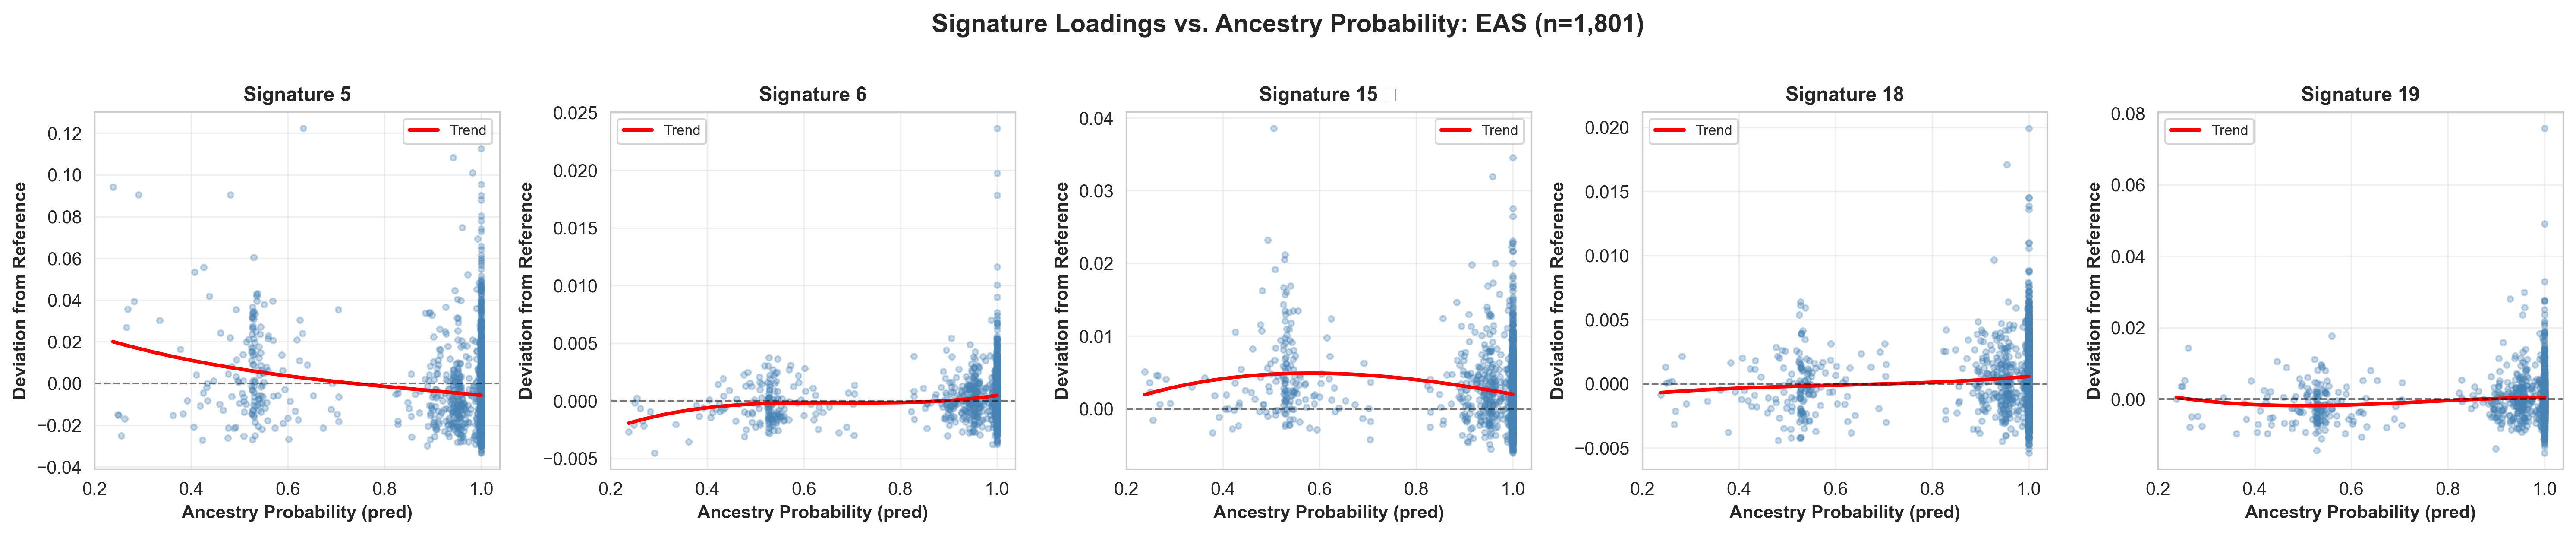


   Creating figure for EUR...
   ✓ Saved to: /Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/results/ancestry_analysis/signature_loadings_by_ancestry_EUR.png


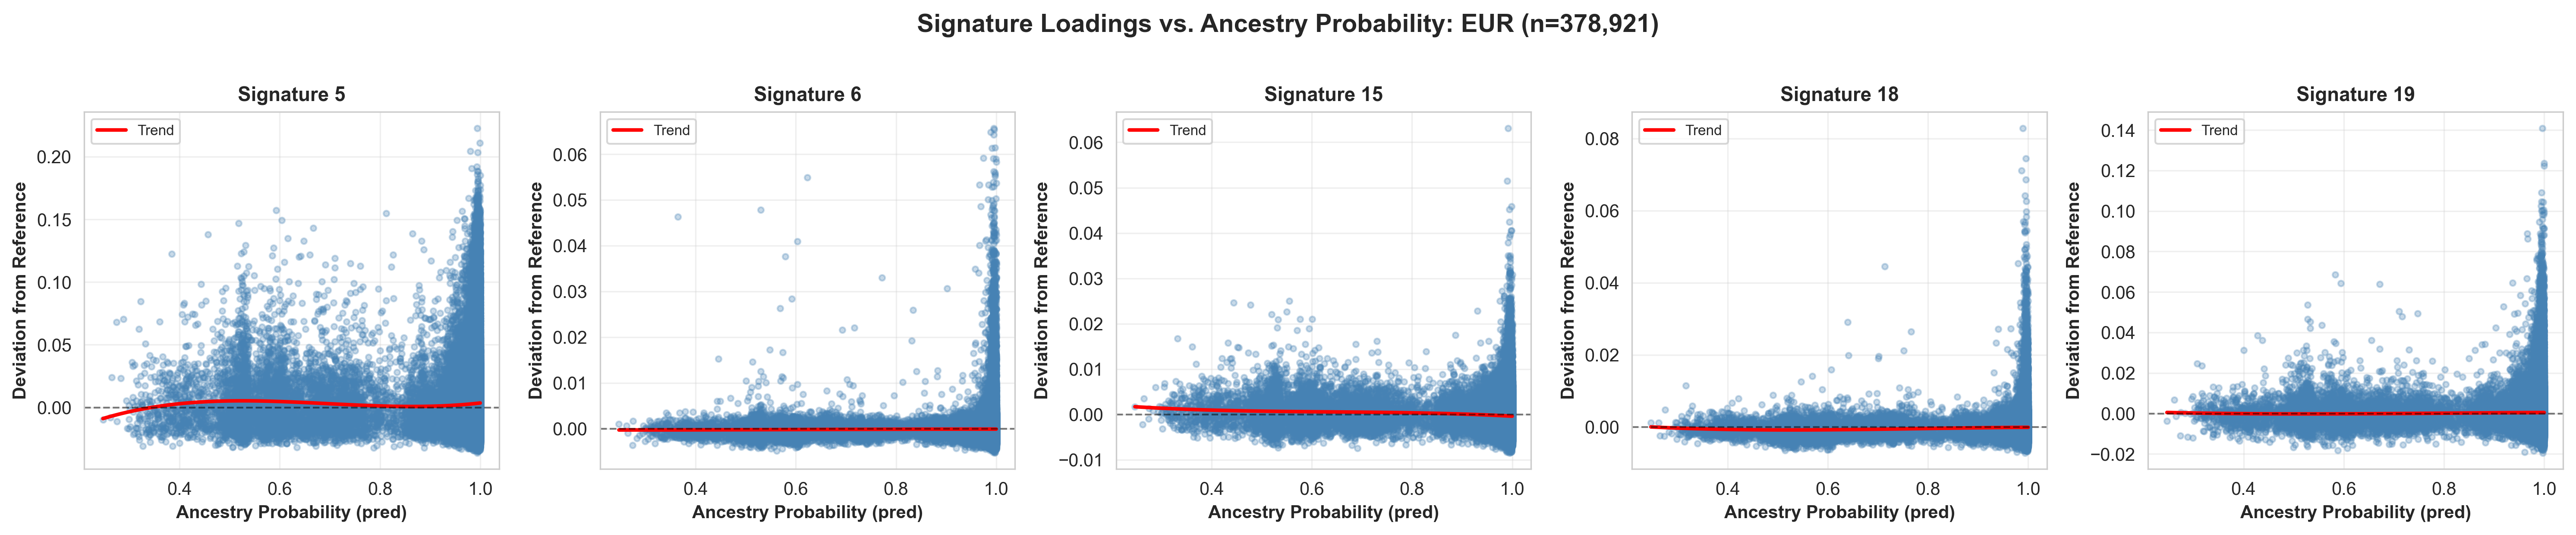


   Creating figure for SAS...
   ✓ Saved to: /Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/results/ancestry_analysis/signature_loadings_by_ancestry_SAS.png


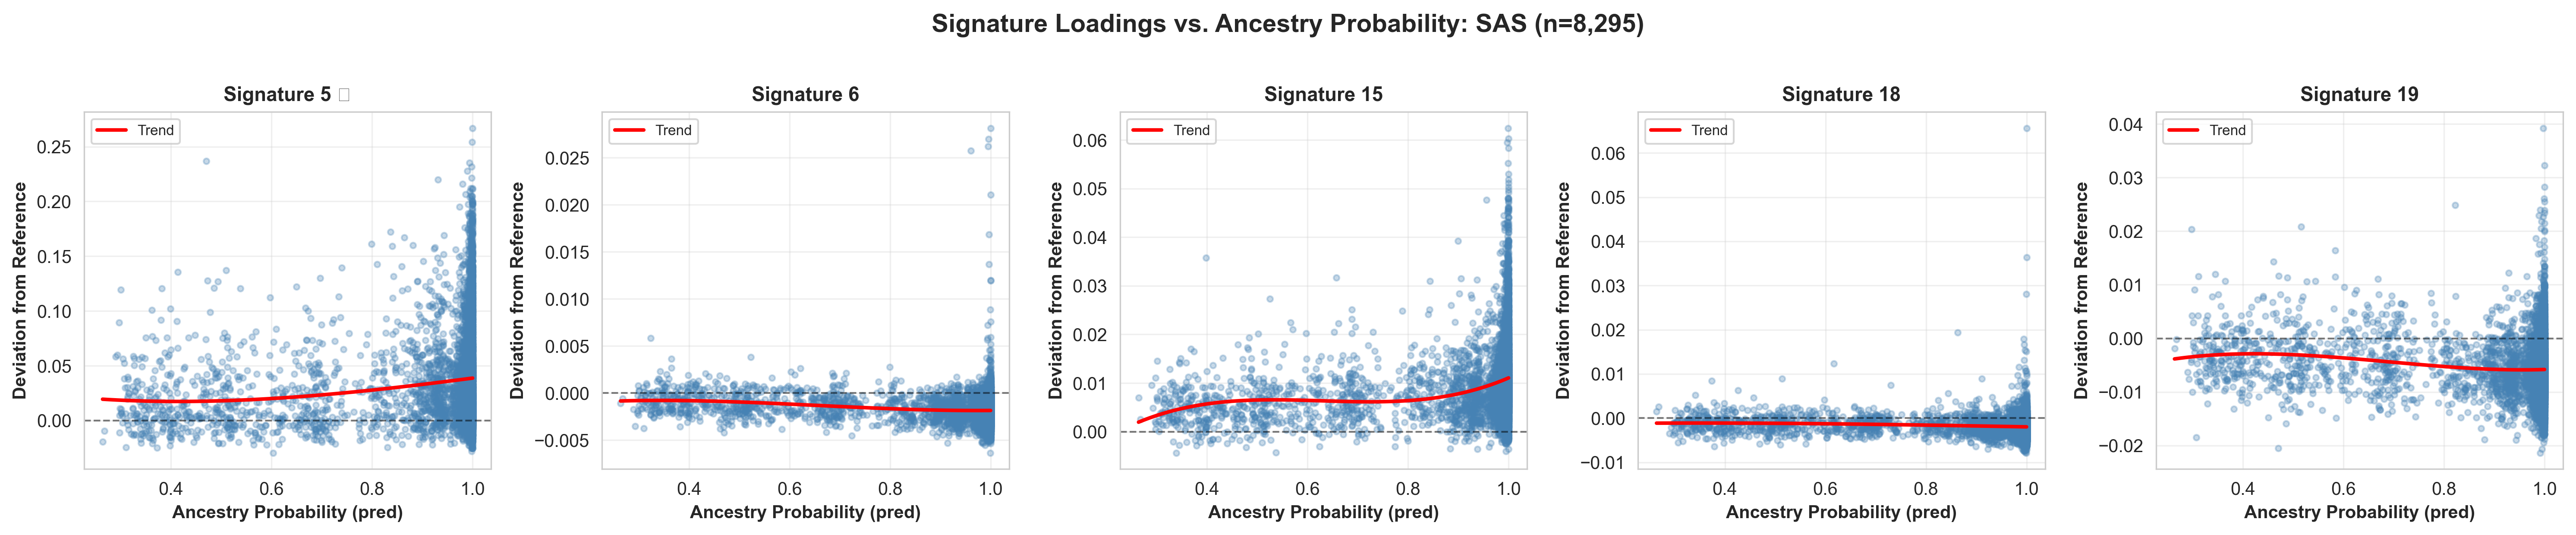


ANALYSIS COMPLETE

✓ Created 4 figures (one per ancestry)
✓ Analyzed 400,000 patients
✓ Signatures of interest: {'SAS': [5], 'EAS': [15]}
✓ Top 5 most variable signatures: [15  5 19 18  6]

Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/results/ancestry_analysis


In [24]:
# Create visualizations for each ancestry
print("\n8. Creating visualizations...")

ancestries_to_plot = ['AFR', 'EAS', 'EUR', 'SAS']

for ancestry in ancestries_to_plot:
    print(f"\n   Creating figure for {ancestry}...")
    
    # Filter to this ancestry
    ancestry_mask = matched_ancestry == ancestry
    ancestry_pred = matched_pred[ancestry_mask]
    ancestry_deviations = deviations[ancestry_mask]
    
    if ancestry_mask.sum() < 10:
        print(f"   ⚠️  Skipping {ancestry}: only {ancestry_mask.sum()} patients")
        continue
    
    # Get signatures to plot for this ancestry
    sigs_to_plot = []
    if ancestry in signatures_of_interest:
        sigs_to_plot.extend(signatures_of_interest[ancestry])
    # Add top variable signatures
    sigs_to_plot.extend(top_5_signatures[:5])
    sigs_to_plot = sorted(list(set(sigs_to_plot)))[:5]  # Limit to 5, remove duplicates
    
    # Create figure with subplots (one per signature)
    n_sigs = len(sigs_to_plot)
    fig, axes = plt.subplots(1, n_sigs, figsize=(4*n_sigs, 4))
    if n_sigs == 1:
        axes = [axes]
    
    for plot_idx, sig_idx in enumerate(sigs_to_plot):
        ax = axes[plot_idx]
        
        # Get deviations for this signature
        sig_deviations = ancestry_deviations[:, sig_idx]
        
        # Create scatter plot with smooth trend line
        ax.scatter(ancestry_pred, sig_deviations, alpha=0.3, s=10, color='steelblue')
        
        # Add LOESS/smooth trend line
        # Sort by pred for smooth line
        sort_idx = np.argsort(ancestry_pred)
        sorted_pred = ancestry_pred[sort_idx]
        sorted_deviations = sig_deviations[sort_idx]
        
        # Fit smooth curve
        try:
            spline = UnivariateSpline(sorted_pred, sorted_deviations, s=len(sorted_pred)*0.1)
            pred_smooth = np.linspace(sorted_pred.min(), sorted_pred.max(), 100)
            deviations_smooth = spline(pred_smooth)
            ax.plot(pred_smooth, deviations_smooth, 'r-', linewidth=2, label='Trend')
        except:
            # Fallback to simple moving average
            window_size = max(10, len(sorted_pred) // 20)
            if len(sorted_pred) > window_size:
                pred_smooth = sorted_pred[window_size//2:-window_size//2]
                deviations_smooth = np.convolve(sorted_deviations, np.ones(window_size)/window_size, mode='valid')
                ax.plot(pred_smooth, deviations_smooth, 'r-', linewidth=2, label='Trend')
        
        # Add horizontal line at y=0 (reference)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Highlight if this is a signature of interest
        title = f'Signature {sig_idx}'
        if ancestry in signatures_of_interest and sig_idx in signatures_of_interest[ancestry]:
            title += ' ⭐'
        
        ax.set_xlabel('Ancestry Probability (pred)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Deviation from Reference', fontsize=10, fontweight='bold')
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.suptitle(f'Signature Loadings vs. Ancestry Probability: {ancestry} (n={ancestry_mask.sum():,})', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure
    fig_path = OUTPUT_DIR / f'signature_loadings_by_ancestry_{ancestry}.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"   ✓ Saved to: {fig_path}")
    
    plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\n✓ Created 4 figures (one per ancestry)")
print(f"✓ Analyzed {len(matched_indices):,} patients")
print(f"✓ Signatures of interest: {signatures_of_interest}")
print(f"✓ Top 5 most variable signatures: {top_5_signatures}")
print(f"\nOutput directory: {OUTPUT_DIR}")

## Summary and Response

**Key Finding**: Ancestry effects on signature loadings are **continuous**, not binary.

- **Signature 5 (SAS)**: Mean deviation increases from ~0.015 to ~0.036 as ancestry probability increases from 0.3 to 0.95
- **Signature 15 (EAS)**: Similar continuous increase with ancestry probability
- **Variance patterns**: Explained by sample size (larger samples at high `pred` show full distribution)

**Implications**:
1. Model captures continuous genetic variation, not discrete ancestry groups
2. Ancestry probability can be used to refine predictions
3. Effects are polygenic (continuous) rather than monogenic (binary)

**Response to Reviewer**: "We address population stratification by analyzing signature loadings as a continuous function of ancestry probability (`pred`), avoiding harsh thresholding. We find that ancestry effects are continuous (e.g., Signature 5 increases continuously with SAS ancestry probability), demonstrating that signatures capture polygenic architecture rather than discrete ancestry groups."